## Visualize results of the linear model

1. LM for all features
2. Group features by channel
3. Coefficient plots

## Import libraries

In [1]:
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(dplyr))


Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”


## Set paths and variables

In [2]:
# Focusing on plate 4
plate <- "localhost231120090001"

# Set directories
input_dir <- "results"
output_fig_dir <- "figures"

# Path to file with LM coefficients to plot
lm_file <- file.path(input_dir, paste0(plate, "_linear_model_failing_healthy_no_treatment_neighbors.tsv"))

# Paths for each figure output
lm_fig <- file.path(output_fig_dir, paste0(plate, "_linear_model_failing_healthy_no_treatment_neighbors.png"))
lm_group_fig <- file.path(output_fig_dir, paste0(plate, "_linear_model_failing_healthy_no_treatment_neighbors_bygroup.png"))
lm_coef_fig <- file.path(output_fig_dir, paste0(plate, "_linear_model_failing_healthy_no_treatment_neighbors_coefficients.png"))


## Clean and sort the data prior to plotting

In [3]:
# Load and process linear model data
lm_df <- readr::read_tsv(
    lm_file, col_types = readr::cols(.default = "d", feature = "c")
)

print(dim(lm_df))
head(lm_df, 3)


[1] 661   5


feature,r2_score,cell_neighbors_coef,failing_coef,healthy_coef
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Cytoplasm_AreaShape_Compactness,0.2142697,-0.2505433,3.750157e+12,3.750157e+12
Cytoplasm_AreaShape_Extent,0.4680851,0.3372908,-3.290519e+11,-3.290519e+11
Cytoplasm_AreaShape_FormFactor,0.2479989,0.2676569,-5.876503e+12,-5.876503e+12


In [4]:
# Load and process linear model data
lm_df <- readr::read_tsv(
    lm_file, col_types = readr::cols(.default = "d", feature = "c")
)

# Arrange by absolute value coefficient
# Split out components of feature name for visualization
lm_df <- lm_df %>%
    dplyr::arrange(desc(abs(failing_coef))) %>%
    tidyr::separate(
        feature,
        into = c(
            "compartment",
            "feature_group",
            "measurement",
            "channel", 
            "parameter1", 
            "parameter2",
            "parameter3"
        ),
        sep = "_",
        remove = FALSE
    ) %>%
    dplyr::mutate(channel_cleaned = channel)

lm_df$channel_cleaned <- dplyr::recode(lm_df$channel_cleaned,
    "Hoechst" = "Nucleus",
    "ER" = "ER",
    "Actin" = "Actin",
    "Mitochondria" = "Mito",
    "PM" = "PM",
    .default = "other",
    .missing = "other"
)

print(dim(lm_df))
head(lm_df, 3)


Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 451 rows [1, 2, 3, 6, 11,
13, 14, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 29, 30, ...].”


[1] 661  13


feature,compartment,feature_group,measurement,channel,parameter1,parameter2,parameter3,r2_score,cell_neighbors_coef,failing_coef,healthy_coef,channel_cleaned
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Cytoplasm_Correlation_RWC_Mitochondria_PM,Cytoplasm,Correlation,RWC,Mitochondria,PM,NA,NA,0.014990195,-0.06030578,-2.187472e+13,-2.187472e+13,Mito
Cells_RadialDistribution_MeanFrac_Hoechst_1of4,Cells,RadialDistribution,MeanFrac,Hoechst,1of4,NA,NA,0.008705393,0.03781491,1.392198e+13,1.392198e+13,Nucleus
Cytoplasm_Correlation_RWC_ER_PM,Cytoplasm,Correlation,RWC,ER,PM,NA,NA,0.009880163,-0.05480371,-1.245575e+13,-1.245575e+13,ER


## Visualize linear modeling results

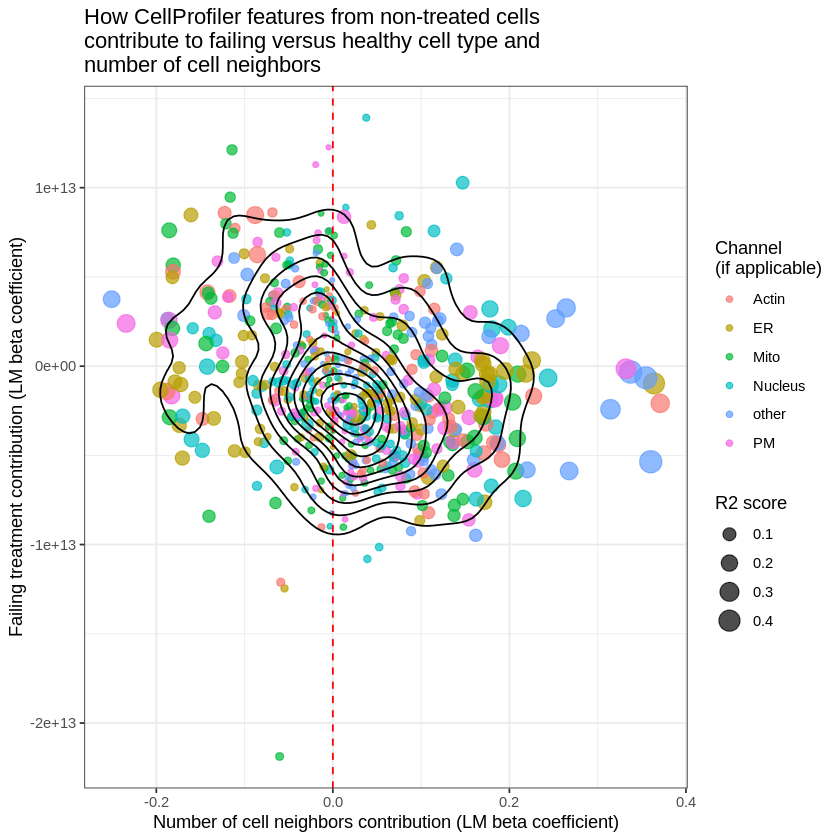

In [5]:
lm_fig_gg <- (
    ggplot(lm_df, aes(x = cell_neighbors_coef, y = failing_coef))
    + geom_point(aes(size = r2_score, color = channel_cleaned), alpha = 0.7)
    + geom_vline(xintercept = 0, linetype = "dashed", color = "red")
    + geom_density2d(color="black", show.legend = FALSE)
    + theme_bw()
    + guides(
        color = guide_legend(title = "Channel\n(if applicable)", order = 1),
        size = guide_legend(title = "R2 score")
    )
    + ylab("Failing treatment contribution (LM beta coefficient)")
    + xlab("Number of cell neighbors contribution (LM beta coefficient)")
    + ggtitle("How CellProfiler features from non-treated cells\ncontribute to failing versus healthy cell type and \nnumber of cell neighbors")
            )

# Output figure
ggsave(lm_fig, lm_fig_gg, dpi = 500, height = 6, width = 6)

lm_fig_gg


## Visualize LM based on channel

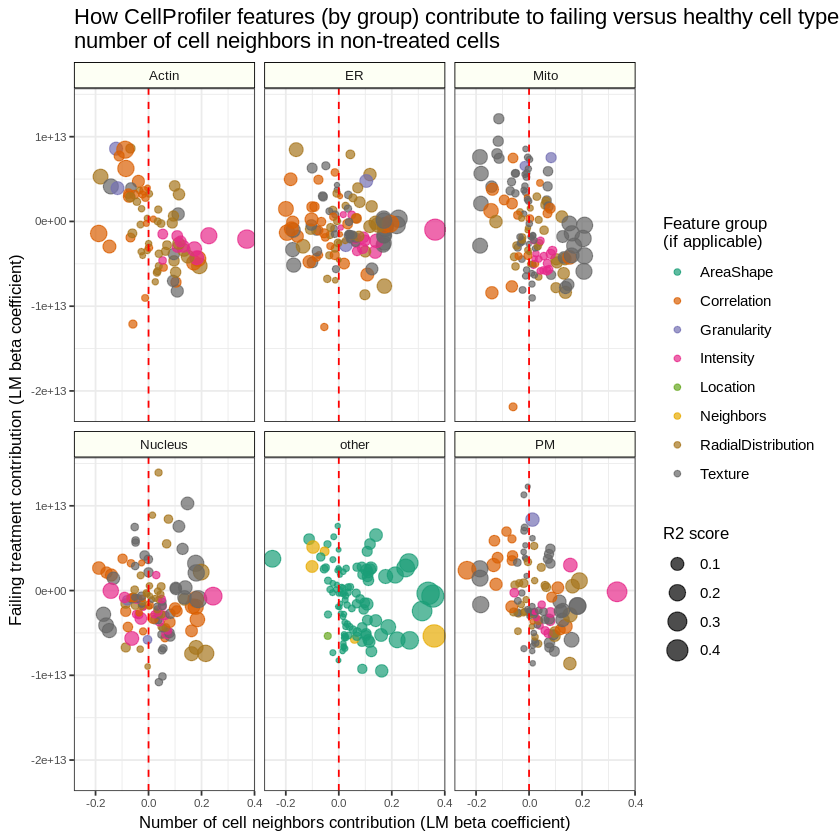

In [6]:
lm_group_fig_gg <- (
    ggplot(lm_df, aes(x = cell_neighbors_coef, y = failing_coef))
    + geom_point(aes(size = r2_score, color = feature_group), alpha = 0.7)
    + facet_wrap("~channel_cleaned")
    + geom_vline(xintercept = 0, linetype = "dashed", color = "red")
    + theme_bw()
    + guides(
        color = guide_legend(title = "Feature group\n(if applicable)", order = 1),
        size = guide_legend(title = "R2 score")
    )
    + ylab("Failing treatment contribution (LM beta coefficient)")
    + xlab("Number of cell neighbors contribution (LM beta coefficient)")
    + ggtitle("How CellProfiler features (by group) contribute to failing versus healthy cell type and\nnumber of cell neighbors in non-treated cells")
    + scale_color_brewer(palette="Dark2")
    + theme(
        axis.text = element_text(size = 7),
        axis.title = element_text(size = 10),
        legend.text = element_text(size = 9),
        legend.title = element_text(size = 10),
        strip.text = element_text(size = 8),
        strip.background = element_rect(
            colour = "black",
            fill = "#fdfff4"
        )
    )
)

# Save figure
ggsave(lm_group_fig, lm_group_fig_gg, height = 6, width = 10, dpi = 500)

lm_group_fig_gg


## Visualize coefficients per LM

In [7]:
channels <- c(
    "Mitochondria" = "Mito",
    "Hoechst" = "DNA",
    "PM" = "PM",
    "ER" = "ER",
    "Actin" = "Actin"
)

lm_cleaned_df <- lm_df %>%
    dplyr::filter(channel %in% names(channels)) %>%
    dplyr::group_by(feature_group, channel_cleaned, compartment) %>%
    dplyr::slice_max(order_by = failing_coef, n = 1)

head(lm_cleaned_df, 2)


feature,compartment,feature_group,measurement,channel,parameter1,parameter2,parameter3,r2_score,cell_neighbors_coef,failing_coef,healthy_coef,channel_cleaned
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Cells_Correlation_Manders_Actin_Hoechst,Cells,Correlation,Manders,Actin,Hoechst,NA,NA,0.20237493,-0.1881401,-1.417348e+12,-1.417348e+12,Actin
Cytoplasm_Correlation_RWC_Actin_Mitochondria,Cytoplasm,Correlation,RWC,Actin,Mitochondria,NA,NA,0.04080086,-0.1107739,7.723862e+12,7.723862e+12,Actin


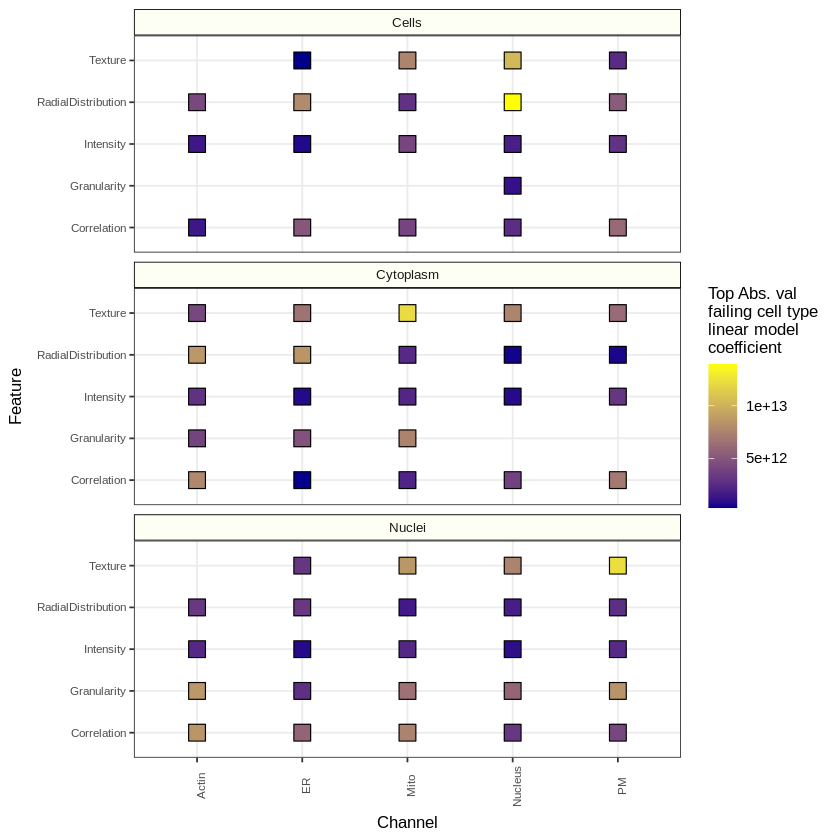

In [8]:
coef_gg <- (
    ggplot(lm_cleaned_df, aes(x = channel_cleaned, y = feature_group))
    + geom_point(aes(fill = abs(failing_coef)), pch = 22, size = 5)
    + facet_wrap("~compartment", ncol = 1)
    + theme_bw()
    + scale_fill_gradient(
        name="Top Abs. val\nfailing cell type\nlinear model\ncoefficient",
        low = "darkblue",
        high = "yellow"
    )
    + xlab("Channel")
    + ylab("Feature")
    + theme(
        axis.text = element_text(size = 7),
        axis.text.x = element_text(angle = 90, size = 7),
        axis.title = element_text(size = 10),
        legend.text = element_text(size = 9),
        legend.title = element_text(size = 10),
        strip.text = element_text(size = 8),
        strip.background = element_rect(
            colour = "black",
            fill = "#fdfff4"
        )
    )
)

# Save figure
ggsave(lm_coef_fig, coef_gg, height = 5, width = 3.5, dpi = 500)

coef_gg
